<a href="https://colab.research.google.com/github/dnrghks5583/Way-that-set-threshold-for-setting-PMD/blob/main/cifar100_Calc_PMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input
from tensorflow.keras.layers import Flatten, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
import math
import tensorflow as tf
from keras.models import load_model

# training parameters
batch_size = 32 # orig paper trained all networks with batch_size=128
epochs = 100
num_classes = 100
data_augmentation = True

# subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 9

# model version
# orig paper: version = 1 (ResNet v1), 
# improved ResNet: version = 2 (ResNet v2)
version = 1
path = '/content/gdrive/My Drive/cifar100'
image_size = (32, 32)
input_shape = (32, 32, 3)
num_classes = 100

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
model_path = '/CIFAR-100_ResNet56v1_model.125.h5'
model = tf.keras.models.load_model(path + model_path) # load model

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

169009152/169001437 [==============================] - 6s 0us/step


In [7]:
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# input image dimensions.
input_shape = x_train.shape[1:]

# normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# if subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('Model_Type : ' , model_type)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

Model_Type :  ResNet56v1
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [8]:
y_pred = model.predict(x_test)
model.evaluate(x_test, y_test)

313/313 [==============================] - 9s 25ms/step - loss: 1.6735 - acc: 0.6983


[1.6734702587127686, 0.6983000040054321]

In [9]:
import tensorflow

cce = tensorflow.keras.losses.categorical_crossentropy(
    y_test,
    y_pred,
    from_logits = False,
    label_smoothing = 0)
cce = cce.numpy()
print(cce)

[6.4812961e+00 2.8651167e-02 6.5820475e+00 ... 6.4373226e-06 2.8256595e-04
 2.9145181e-01]


In [10]:
def classification_Cce(cce, y_test, y_pred) :
  c = []
  m = []
  c_i = []

  for i in range(len(y_test)) :
    if np.argmax(y_test[i]) == np.argmax(y_pred[i]) :
      c.append(cce[i])
      c_i.append(i)
    else :
      m.append(cce[i])

  return c, m, c_i

In [11]:
collect_Cce, missclassification_Cce, collect_Idx = classification_Cce(cce, y_test, y_pred)
print(len(collect_Cce))
print(len(missclassification_Cce))

6983
3017


In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

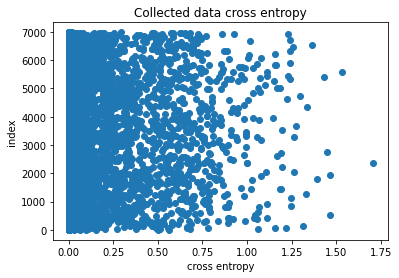

In [13]:
x_value = []
for i in range(len(collect_Cce)) :
  x_value.append(i)

plt.scatter(collect_Cce, x_value)
plt.title('Collected data cross entropy')
plt.ylabel('index')
plt.xlabel('cross entropy')
plt.show()

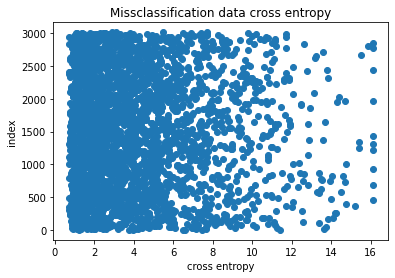

In [15]:
X_value = []
for i in range(len(missclassification_Cce)) :
  X_value.append(i)

plt.scatter(missclassification_Cce, X_value)
plt.title('Missclassification data cross entropy')
plt.ylabel('index')
plt.xlabel('cross entropy')
plt.show()

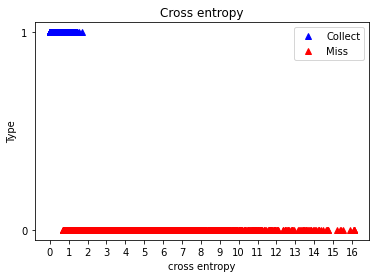

In [16]:
Y = []
for i in range(len(collect_Cce)) :
  Y.append(1)
y = []
for i in range(len(missclassification_Cce)) :
  y.append(0)

values = [0, 1, 2, 3, 4, 5, 6, 7, 8 ,9, 10, 11, 12 ,13, 14, 15, 16]

plt.plot(collect_Cce, Y, 'b^', missclassification_Cce, y, 'r^')
plt.title('Cross entropy')
plt.ylabel('Type')
plt.xlabel('cross entropy')
plt.legend(['Collect', 'Miss'])
plt.yticks([1,0])
plt.xticks(values)

plt.show()

In [17]:
print(max(collect_Cce))
print(min(missclassification_Cce))

1.7059131
0.70325565


In [18]:
section = []
section_rate = []
max_m = round(max(missclassification_Cce))

for i in range(max_m+1) :
  section.append(0)

for m in missclassification_Cce :
  section[round(m)] = section[round(m)] + 1

  
for i in range(max_m+1):
    section_rate.append(section[i]/len(missclassification_Cce))

print(section)
print(section_rate)

[0, 510, 572, 449, 378, 333, 202, 156, 118, 93, 65, 53, 30, 20, 18, 8, 12]
[0.0, 0.16904209479615512, 0.18959231024196221, 0.14882333443818363, 0.12529002320185614, 0.11037454424925422, 0.06695392774279085, 0.05170699370235333, 0.0391117003646006, 0.03082532316871064, 0.02154458070931389, 0.01756711965528671, 0.009943652635067949, 0.006629101756711966, 0.005966191581040769, 0.002651640702684786, 0.003977461054027179]


In [19]:
def static_Threshold() :
  threshold = []
  for i in range(1, 10):
    threshold.append(round(i * 0.1, 1))
  return threshold

In [20]:
staticThreshold = static_Threshold()
print(staticThreshold)

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


In [21]:
def dynamic_Threshold(missclassification_Cce, cce) :
  #Z = [1.96, 2.17, 2.576] # 95%, 97%, 99% two-tails
  Z = [1.645, 1.96, 2.326] # 95%, 97.5%, 99% one-tails
  threshold = [min(missclassification_Cce)]
  x_ = np.mean(cce)
  o = np.std(missclassification_Cce)
  n_ = (len(missclassification_Cce))**0.5

  for z in Z :
    threshold.append(x_- (z * o)/n_)
  
  return threshold

In [22]:
dynamicThreshold = dynamic_Threshold(missclassification_Cce, cce)
print(dynamicThreshold)

[0.70325565, 1.2572672073494973, 1.2402743461480559, 1.2205302597997145]


In [23]:
def detection(threshold, cce, collect) : 
  PMD = []
  for i in collect :
    if cce[i] > threshold :
        PMD.append(i)
  return PMD

In [24]:
def detection_PMD(list_of_threshold, cce, collect):
  PMD_by_threshold = []

  for th in list_of_threshold :
    PMD_by_threshold.append(detection(th, cce, collect))
  return PMD_by_threshold

In [25]:
PMD_By_Static_Threshold  = detection_PMD(staticThreshold, cce, collect_Idx)
PMD_By_Dynamic_Threshold = detection_PMD(dynamicThreshold, cce, collect_Idx)

In [26]:
print(len(PMD_By_Static_Threshold))
print(PMD_By_Static_Threshold)
print(len(PMD_By_Dynamic_Threshold))
print(PMD_By_Dynamic_Threshold)

9
[[9, 12, 17, 22, 37, 40, 41, 54, 61, 71, 83, 87, 89, 95, 98, 99, 102, 118, 140, 141, 151, 158, 164, 165, 183, 188, 191, 192, 206, 208, 209, 212, 229, 249, 256, 260, 268, 269, 272, 274, 284, 290, 291, 298, 300, 301, 326, 330, 343, 350, 365, 366, 367, 368, 376, 379, 389, 390, 393, 398, 399, 408, 427, 436, 437, 438, 439, 443, 452, 454, 456, 473, 503, 506, 522, 523, 534, 537, 540, 545, 548, 549, 553, 560, 580, 583, 584, 590, 596, 598, 608, 613, 616, 639, 640, 645, 670, 683, 686, 688, 689, 693, 704, 706, 708, 711, 717, 719, 724, 727, 731, 732, 733, 739, 743, 744, 746, 756, 757, 759, 763, 769, 778, 780, 792, 798, 804, 822, 826, 835, 836, 838, 840, 841, 842, 850, 863, 892, 910, 924, 925, 929, 957, 958, 965, 967, 971, 984, 985, 987, 993, 995, 1005, 1011, 1016, 1017, 1020, 1023, 1046, 1047, 1053, 1054, 1058, 1060, 1077, 1087, 1088, 1098, 1101, 1108, 1113, 1114, 1120, 1124, 1127, 1140, 1141, 1146, 1149, 1150, 1153, 1157, 1158, 1161, 1168, 1169, 1172, 1174, 1177, 1179, 1183, 1188, 1196, 1197, 1

In [27]:
import cv2

In [28]:
def rotate_img_set(data_set, angle) : # 10' ~ 90'
  rotated_img = []
  print("rotate " + str(angle) + "degree")
  for img in data_set :
    m = cv2.getRotationMatrix2D((16,16), angle, 1)  # center dot
    new_img = cv2.warpAffine(img, m, image_size, cv2.INTER_AREA, borderMode = 1)
    rotated_img.append(new_img)
    
  return rotated_img

In [29]:
def img_trim(img, size) :
  w = 32
  h = 32
  new_img = img[size:size+h, size:size+w]
  return new_img

In [30]:
def size_Adjust(x_test, rate) :

  new_data_set = []
  if rate > 1 : # aggmentation
    print("augmentation " + str(rate) + "%")
    size = round(32*rate/2 - 16)
    for img in x_test :
      new_img = cv2.resize(img, None, fx = rate, fy = rate, interpolation = cv2.INTER_LINEAR)
      new_img = img_trim(new_img, size)
      new_data_set.append(new_img)
  else :  # reduction
    print("reduction " + str(rate) + "%")
    size = round(16 * (1-rate))
    for img in x_test :
      new_img = cv2.resize(img, None, fx = rate, fy = rate, interpolation = cv2.INTER_AREA)
      new_img = np.pad(new_img, ((size, size), (size, size), (0, 0)), mode = 'edge')
      new_img = cv2.resize(new_img, image_size, interpolation = cv2.INTER_AREA)
      new_data_set.append(new_img)

  return new_data_set

In [31]:
def get_MD(y_pred, new_y_pred, y_test) :
  MD = []
  for i in range(len(y_pred)) :
    if np.argmax(y_pred[i]) == np.argmax(y_test[i]) and np.argmax(new_y_pred[i]) != np.argmax(y_test[i]) :
      MD.append(i)
  print("    Find MD : " + str(len(MD)))
  return MD

In [32]:
def calc_Acc(new_y_pred, y_test) :
  cnt = 0
  for i in range(len(y_pred)) :
    if np.argmax(new_y_pred[i]) == np.argmax(y_test[i]) :
      cnt = cnt + 1
  acc = cnt/len(y_pred)
  print("  Acc : " + str(acc))

In [33]:
def get_PMD_Precision(MD, PMD) :
  cnt = 0
  if len(PMD) == 0 :
    return 0
  for data in PMD : 
    if data in MD :
      cnt = cnt + 1
  precision = cnt/len(PMD)
  print("        Precision : " + str(precision))
  return precision

In [34]:
def get_PMD_Recall(MD, PMD) :
  cnt = 0
  if len(MD) == 0 :
    return 0
  for data in MD : 
    if data in PMD :
      cnt = cnt + 1
  recall = cnt/len(MD)
  print("        Recall : " + str(recall))
  return recall

In [35]:
def get_Result(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, data_set, y_pred, y_test) : #
  Stp = []   # [ th = 0.1_pre1, th = 0.2_pre2, ... , th = 0.9_pre9 ] number of elements = 9
  Dtp = []   # [ th = min_pre1, th = 95%_pre2, ... , th = 99%_pre4 ] number of elements = 4
  Str = []   # [ th = 0.1_rec1, th = 0.2_rec2, ... , th = 0.9_rec9 ] number of elements = 9
  Dtr = []   # [ th = min_rec1, th = 95%_rec2, ... , th = 99%_rec4 ] number of elements = 4
  st = 1
  dt = 1

  new_y_pred = model.predict(data_set)
  calc_Acc(new_y_pred, y_test)
  MD = get_MD(y_pred, new_y_pred, y_test)

  print("      " + "static threshold")
  for s in PMD_By_Static_Threshold :
    print("        " + str(st) + "st static threshold")
    st = st + 1
    Stp.append(get_PMD_Precision(MD, s))
    Str.append(get_PMD_Recall(MD, s))
    print()

  print("      " + "dynamic threshold")
  for d in PMD_By_Dynamic_Threshold :
    print("        " + str(dt) + "st dynamic threshold")
    dt = dt + 1
    Dtp.append(get_PMD_Precision(MD, d))
    Dtr.append(get_PMD_Recall(MD, d))
    print()

  return Stp, Dtp, Str, Dtr

In [36]:
def get_Avg_Result(lists) : #
  x = len(lists[0]) # static = 9, dynamic = 4
  y = len(lists)    # aggmentation, reduction = 4, rotate = 9
  Avg = []

  for i in range(x) :
    temp = 0
    for j in range(y) :
      temp = temp + lists[j][i]
    Avg.append(temp/y)
  return Avg

In [37]:
def validation(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, y_pred, y_test, list_of_rate, rotated = False) : #

  stp_Result = []
  dtp_Result = []
  str_Result = []
  dtr_Result = []

  for rate in list_of_rate :
    if rotated :
      data_set = rotate_img_set(x_test, rate)
    else :
      data_set = size_Adjust(x_test, rate)
    data_set = np.array(data_set)

    Stp, Dtp, Str, Dtr = get_Result(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, data_set, y_pred, y_test)
    stp_Result.append(Stp)
    dtp_Result.append(Dtp)
    str_Result.append(Str)
    dtr_Result.append(Dtr)

  stp_Result = get_Avg_Result(stp_Result)
  dtp_Result = get_Avg_Result(dtp_Result)
  str_Result = get_Avg_Result(str_Result)
  dtr_Result = get_Avg_Result(dtr_Result)
  return stp_Result, dtp_Result, str_Result, dtr_Result

In [38]:
def print_Result(stp_Result, dtp_Result, str_Result, dtr_Result, comments, staticThreshold, dynamicThreshold) :
  print(comments)
  print(staticThreshold)
  print(stp_Result)
  print(str_Result)
  print(dynamicThreshold)
  print(dtp_Result)
  print(dtr_Result)

In [39]:
list_of_ag_rate = [1.1, 1.2, 1.3, 1.4]
list_of_rd_rate = [0.9, 0.8, 0.7, 0.6]
list_of_degree = [10, 20, 30, 40, 50, 60 ,70, 80 ,90]

In [40]:
rot_Stp, rot_Dtp, rot_Str, rot_Dtr = validation(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, y_pred, y_test, list_of_degree, True)   ## rotated

rotate 10degree
  Acc : 0.6622
    Find MD : 903
      static threshold
        1st static threshold
        Precision : 0.3623529411764706
        Recall : 0.6821705426356589

        2st static threshold
        Precision : 0.4174917491749175
        Recall : 0.5603543743078627

        3st static threshold
        Precision : 0.4504896626768226
        Recall : 0.4584717607973422

        4st static threshold
        Precision : 0.4822190611664296
        Recall : 0.3754152823920266

        5st static threshold
        Precision : 0.5027223230490018
        Recall : 0.3067552602436323

        6st static threshold
        Precision : 0.5314861460957179
        Recall : 0.2336655592469546

        7st static threshold
        Precision : 0.548
        Recall : 0.15171650055370986

        8st static threshold
        Precision : 0.5949367088607594
        Recall : 0.10409745293466224

        9st static threshold
        Precision : 0.6153846153846154
        Recall : 0.070874861572

In [41]:
ag_Stp, ag_Dtp, ag_Str, ag_Dtr = validation(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, y_pred, y_test, list_of_ag_rate, False)    ## augmentation

augmentation 1.1%
  Acc : 0.6783
    Find MD : 804
      static threshold
        1st static threshold
        Precision : 0.3388235294117647
        Recall : 0.7164179104477612

        2st static threshold
        Precision : 0.38366336633663367
        Recall : 0.5783582089552238

        3st static threshold
        Precision : 0.4102285092491839
        Recall : 0.4689054726368159

        4st static threshold
        Precision : 0.44096728307254623
        Recall : 0.3855721393034826

        5st static threshold
        Precision : 0.4537205081669691
        Recall : 0.31094527363184077

        6st static threshold
        Precision : 0.4634760705289673
        Recall : 0.22885572139303484

        7st static threshold
        Precision : 0.496
        Recall : 0.15422885572139303

        8st static threshold
        Precision : 0.5316455696202531
        Recall : 0.1044776119402985

        9st static threshold
        Precision : 0.5865384615384616
        Recall : 0.0758706

In [42]:
rd_Stp, rd_Dtp, rd_Str, rd_Dtr = validation(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, y_pred, y_test, list_of_rd_rate, False)   ## reduction

reduction 0.9%
  Acc : 0.6608
    Find MD : 1034
      static threshold
        1st static threshold
        Precision : 0.39176470588235296
        Recall : 0.6441005802707931

        2st static threshold
        Precision : 0.44471947194719474
        Recall : 0.5212765957446809

        3st static threshold
        Precision : 0.47986942328618065
        Recall : 0.42649903288201163

        4st static threshold
        Precision : 0.5106685633001422
        Recall : 0.3471953578336557

        5st static threshold
        Precision : 0.5553539019963702
        Recall : 0.29593810444874274

        6st static threshold
        Precision : 0.5617128463476071
        Recall : 0.21566731141199227

        7st static threshold
        Precision : 0.616
        Recall : 0.14893617021276595

        8st static threshold
        Precision : 0.6582278481012658
        Recall : 0.10058027079303675

        9st static threshold
        Precision : 0.6442307692307693
        Recall : 0.064796

In [43]:
print_Result(rot_Stp, rot_Dtp, rot_Str, rot_Dtr, "Rotation", staticThreshold, dynamicThreshold)

Rotation
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
[0.6832679738562092, 0.7029702970297029, 0.7161165518075204, 0.7321005215742058, 0.7420850978019762, 0.7509095997760986, 0.7644444444444445, 0.7925457102672292, 0.7948717948717949]
[0.3437550378096134, 0.2579395411459513, 0.20175675901282833, 0.15940720931271615, 0.1274703373777909, 0.09403507543087018, 0.06046182085512053, 0.040026567168848844, 0.026614882632583495]
[0.70325565, 1.2572672073494973, 1.2402743461480559, 1.2205302597997145]
[0.7638326585695007, 0.7259259259259259, 0.7660818713450293, 0.7777777777777777]
[0.059861347099222556, 0.003683714822696943, 0.0047815313945132965, 0.0063596455107138095]


In [44]:
print_Result(ag_Stp, ag_Dtp, ag_Str, ag_Dtr, "Augmentation", staticThreshold, dynamicThreshold)

Augmentation
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
[0.4427941176470588, 0.4738036303630363, 0.5021762785636561, 0.5245376955903271, 0.5313067150635209, 0.5503778337531486, 0.5830000000000001, 0.6123417721518987, 0.6346153846153846]
[0.5352717580417478, 0.41444983579807954, 0.33462418163094193, 0.2688526658783515, 0.21453286134199157, 0.15951613779973198, 0.10713487624798439, 0.07159822180481817, 0.04957396032747069]
[0.70325565, 1.2572672073494973, 1.2402743461480559, 1.2205302597997145]
[0.5809716599190283, 0.6666666666666667, 0.6052631578947368, 0.6000000000000001]
[0.10566997577320754, 0.0068981591130377285, 0.008285091112092698, 0.010723366371994163]


In [45]:
print_Result(rd_Stp, rd_Dtp, rd_Str, rd_Dtr, "Reduction", staticThreshold, dynamicThreshold)

Reduction
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
[0.5279411764705882, 0.5691006600660066, 0.5982045701849836, 0.6198435277382646, 0.6433756805807622, 0.6486146095717884, 0.69, 0.7167721518987342, 0.7307692307692307]
[0.5169984747648695, 0.4041280373103211, 0.3251438025368054, 0.2606832456538651, 0.2147425839616983, 0.156732649590428, 0.10564080505938192, 0.06971280362681061, 0.04623185442587848]
[0.70325565, 1.2572672073494973, 1.2402743461480559, 1.2205302597997145]
[0.6902834008097166, 0.6833333333333333, 0.7236842105263157, 0.75]
[0.10435233459205578, 0.006343757261066967, 0.008732283555045225, 0.011783272437029388]
